# Navigation

The purpose of this notebook is to review and visualize functionality in this app. Without these
visualizations it's become increasingly difficult to test navigation behavior.

In [1]:
import os

os.chdir("../")

In [2]:
from trader.dao.dao import DAO

dao = DAO()

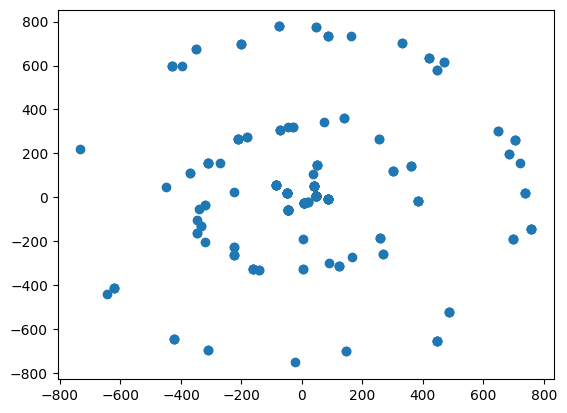

In [3]:
from trader.dao.waypoints import get_waypoints_by_system_symbol
import matplotlib.pyplot as plt
import numpy as np

system_symbol = "X1-BA28"
waypoints = get_waypoints_by_system_symbol(
    engine=dao.engine, system_symbol=system_symbol
)
data = np.array([[waypoint.x, waypoint.y] for waypoint in waypoints])
x, y = data.T
plt.scatter(x, y)
plt.show()

Total distance if sequential: 41030.93814542711
Shortest travel distance: 8700.089710591015


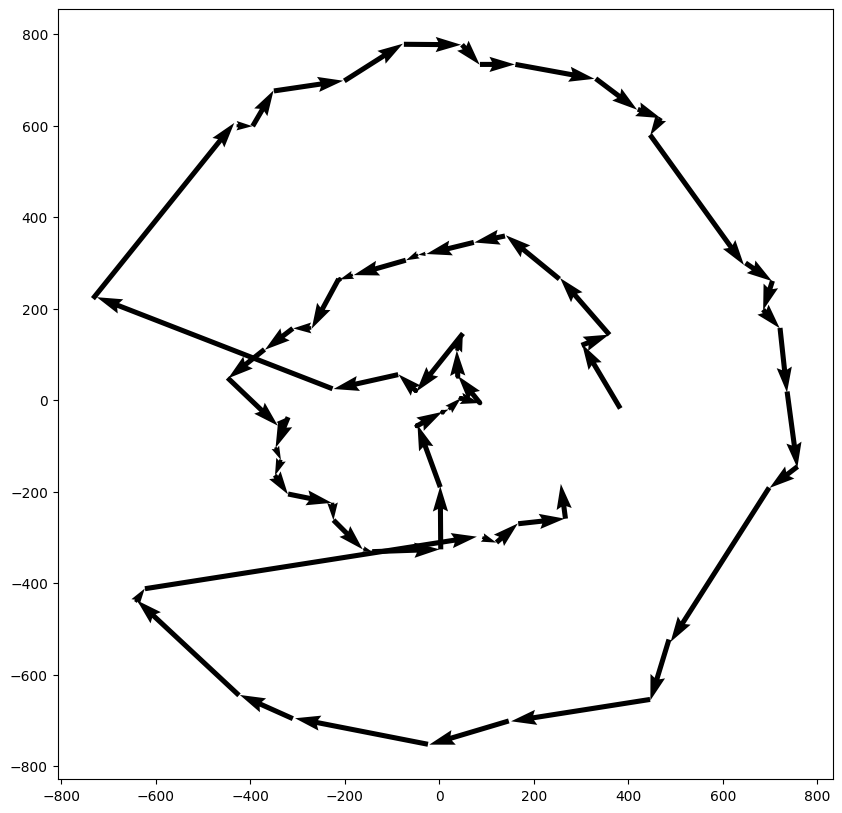

In [4]:
# Traveling salesman (explorer) of all waypoints
from math import dist

import matplotlib.pyplot as plt
import pandas as pd

from trader.dao.waypoints import get_waypoints_by_system_symbol
from trader.roles.navigator.geometry import (
    generate_graph_from_waypoints_all_connected,
    generate_shortest_path_with_graph,
)

cols = ["x1", "y1", "x2", "y2"]
waypoints = get_waypoints_by_system_symbol(
    engine=dao.engine, system_symbol=system_symbol
)
segments = []
graph = generate_graph_from_waypoints_all_connected(waypoints=waypoints)
path = generate_shortest_path_with_graph(
    starting_position=waypoints[23].symbol, graph=graph
)

default_distance = 0
for idx, waypoint in enumerate(waypoints):
    if idx != len(waypoints) - 1:
        default_distance += dist(
            [waypoint.x, waypoint.y], [waypoints[idx + 1].x, waypoints[idx + 1].y]
        )

distance = 0
for idx, path_node in enumerate(path):
    if idx != len(path) - 1:
        distance += dist([path_node.x, path_node.y], [path[idx + 1].x, path[idx + 1].y])
        segments.append([path_node.x, path_node.y, path[idx + 1].x, path[idx + 1].y])

print(f"Total distance if sequential: {default_distance}")
print(f"Shortest travel distance: {distance}")

df = pd.DataFrame(segments, columns=cols)
_, axis = plt.subplots(figsize=(10, 10))
axis.quiver(df.x1, df.y1, df.x2 - df.x1, df.y2 - df.y1, units="xy", scale=1)
plt.show()

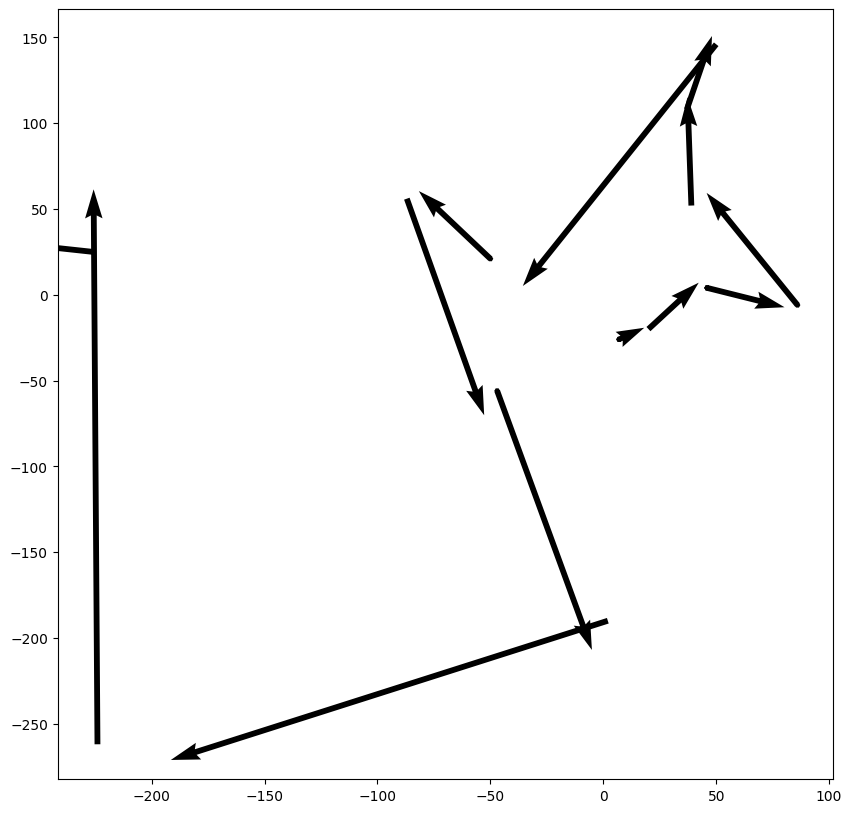

In [5]:
# Traveling salesman (explorer) of all only locations with trading value (marketplace/shipyard)
from math import dist

import matplotlib.pyplot as plt
import pandas as pd

from trader.dao.waypoints import get_waypoints_by_system_symbol
from trader.roles.navigator.geometry import (
    generate_graph_from_waypoints_all_connected,
    generate_shortest_path_with_graph,
)

cols = ["x1", "y1", "x2", "y2"]
waypoints = get_waypoints_by_system_symbol(
    engine=dao.engine, system_symbol=system_symbol
)
market_waypoints = []
acceptable_market_traits = ["MARKETPLACE", "SHIPYARD"]
for waypoint in waypoints:
    for acceptable_market_trait in acceptable_market_traits:
        if acceptable_market_trait in [trait.symbol for trait in waypoint.traits]:
            market_waypoints.append(waypoint)
            break

segments = []
graph = generate_graph_from_waypoints_all_connected(waypoints=market_waypoints)
path = generate_shortest_path_with_graph(
    starting_position=market_waypoints[0].symbol, graph=graph
)

for idx, path_node in enumerate(path):
    if idx != len(path) - 1:
        segments.append([path_node.x, path_node.y, path[idx + 1].x, path[idx + 1].y])

df = pd.DataFrame(segments, columns=cols)
_, axis = plt.subplots(figsize=(10, 10))
axis.quiver(df.x1, df.y1, df.x2 - df.x1, df.y2 - df.y1, units="xy", scale=1)
plt.show()

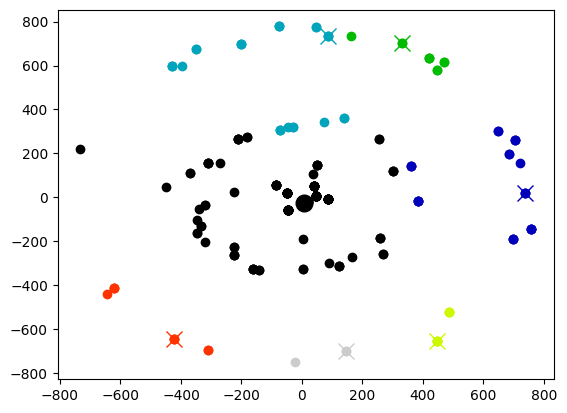

In [6]:
# Refueling and targeting groups of nodes via clustering to find optimal refueling
# locations if applicable, so try to remain in the same cluster in most cases
# for trading + refueling
import matplotlib.pyplot as plt
import pandas as pd
from numpy import unique, where
from sklearn.cluster import MeanShift, estimate_bandwidth

from trader.dao.waypoints import get_waypoints_by_system_symbol
from trader.roles.navigator.geometry import (
    generate_graph_from_waypoints_means_shift_clustering,
)

waypoints = get_waypoints_by_system_symbol(
    engine=dao.engine, system_symbol=system_symbol
)
graph = generate_graph_from_waypoints_means_shift_clustering(waypoints=waypoints)

idx = 0
color_map = plt.get_cmap("nipy_spectral", len(graph.nodes))
for cluster_symbol, cluster_data in graph.nodes.items():
    if cluster_data["market_waypoint_found"]:
        symbol = "o"
    else:
        symbol = "x"
    plt.plot(
        cluster_data["waypoint"].x,
        cluster_data["waypoint"].y,
        symbol,
        markersize=12,
        color=color_map(idx),
    )
    plt.scatter(
        [waypoint.x for waypoint in cluster_data["cluster_waypoints"]],
        [waypoint.y for waypoint in cluster_data["cluster_waypoints"]],
        color=color_map(idx),
    )
    idx += 1
plt.show()